In [7]:
%matplotlib notebook

import matplotlib as mpl
import DataSetQuery
import datetime
import pandas as pd
import MalardHelpers
import geopandas as gp
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from shapely.geometry import Polygon, Point
from osgeo import gdal
import os
import numpy as np
from scipy.interpolate import griddata
import pandas as  pd
import geopandas as gp
from osgeo import gdal
import os
import json
import math
from pandas.io.json import json_normalize


In [8]:
environmentName = 'DEVv2'
query = DataSetQuery.DataSetQuery('http://localhost:9000',environmentName)

# 400000 500000 0 100000 mtngla testdataset HMA RGIv60 SDCv10 DebugRun
parentDsName = 'mtngla'
dataset = 'Ready5'
runName='TestRun5'
region='himalayas'

#Setup the bounding box
minX=500000
maxX=600000
minY=0
maxY=100000
bbx = query.getDataSetBoundingBox(parentDsName, dataset, region)
bbx = json.loads(bbx)
minT = datetime.datetime.utcfromtimestamp(bbx['minTime'])
maxT = datetime.datetime.utcfromtimestamp(bbx['maxTime'])

#The overall data cube for the two datasets
print(query.getDataSetBoundingBox(parentDsName,dataset, region))

{"gridCellMinX":-1600000,"gridCellMaxX":1400000,"gridCellMinY":-1000000,"gridCellMaxY":800000,"minTime":1279266673,"maxTime":1556338066,"totalPoints":2809617,"numberOfShards":258}


In [9]:
fp = query.executeQuery( parentDsName,dataset,region,minX,maxX,minY,maxY,minT,maxT,[],[])
df = MalardHelpers.getDataFrameFromNetCDF(fp)

In [10]:
df.head()

,index,lon,lat,elev,heading,demDiff,demDiffMad,demDiffMad2,phaseAmb,meanDiffSpread,...,phaseSSegment,phaseConfidence,coh,x,y,time,swathFileId,within_Debris,refElevation,refDifference
0,9329,91.211064,36.618717,5225.323242,185.679764,6.810401,1.012953,0.81013,1,5.96258,...,NaN,NaN,0.981,545087.808108,86988.566011,1308838171,7083,0,5219.641138,5.682104
1,9330,91.210834,36.618736,5224.701172,185.679764,6.188429,1.012953,0.81013,1,5.96258,...,NaN,NaN,0.972,545067.492752,86989.441995,1308838171,7083,0,5219.190621,5.510551
2,9331,91.210708,36.618747,5224.254883,185.679764,5.742178,1.012953,0.81013,1,5.96258,...,NaN,NaN,0.996,545056.369909,86989.921603,1308838171,7083,0,5218.947687,5.307195
3,9332,91.210680,36.618749,5223.974121,185.679764,5.461620,1.012953,0.81013,1,5.96258,...,NaN,NaN,0.998,545053.939016,86990.026420,1308838171,7083,0,5218.894489,5.079632
4,9333,91.210673,36.618750,5223.727539,185.679764,5.215077,1.012953,0.81013,1,5.96258,...,NaN,NaN,0.998,545053.293799,86990.054241,1308838171,7083,0,5218.880352,4.847187


In [5]:
df.columns

Index(['index', 'lon', 'lat', 'elev', 'heading', 'demDiff', 'demDiffMad',
       'demDiffMad2', 'phaseAmb', 'meanDiffSpread', 'wf_number', 'sampleNb',
       'power', 'powerdB', 'phase', 'phaseS', 'phaseSSegment',
       'phaseConfidence', 'coh', 'x', 'y', 'time', 'swathFileId',
       'within_Debris', 'refElevation', 'refDifference'],
      dtype='object')

In [11]:
size=100000
year = []
month = []
yearmonth = []
day = []
dateobject = []
xdiff = []
ydiff = []
# glacial year
gla_year = []
for i, row in df.iterrows():
    date = datetime.datetime.utcfromtimestamp(df.time[i])
    year.append(date.year)
    month.append(date.month)
    day.append(date.day)
    dateobject.append(date)
    yearmonth.append('%s-%s' % (date.year, date.month))
    # x and y distance to center point of gridcell
    xdiff.append((df.x[i] % size) - (size/2))
    ydiff.append((df.y[i] % size) - (size/2))
    if date.month < 11:
        gla_year.append(date.year)
    else:
        gla_year.append(date.year+1)
    
df['year'] = year
df['gla_year'] = gla_year
df['month'] = month
df['day'] = day
df['dateobject'] = dateobject
df['yearmonth'] = yearmonth
df['offsetX'] = xdiff
df['offsetY'] = ydiff
df[df.columns[10:25]]

,wf_number,sampleNb,power,powerdB,phase,phaseS,phaseSSegment,phaseConfidence,coh,x,y,time,swathFileId,within_Debris,refElevation
0,1254,149,10906.602539,-150.110352,6.418027,NaN,NaN,NaN,0.981,545087.808108,86988.566011,1308838171,7083,0,5219.641138
1,1254,150,17260.763672,-148.463791,6.408404,NaN,NaN,NaN,0.972,545067.492752,86989.441995,1308838171,7083,0,5219.190621
2,1254,151,26708.033203,-140.894562,6.403134,NaN,NaN,NaN,0.996,545056.369909,86989.921603,1308838171,7083,0,5218.947687
3,1254,152,35719.296875,-136.901062,6.401981,NaN,NaN,NaN,0.998,545053.939016,86990.026420,1308838171,7083,0,5218.894489
4,1254,153,37907.039062,-137.854858,6.401673,NaN,NaN,NaN,0.998,545053.293799,86990.054241,1308838171,7083,0,5218.880352
5,1254,154,35590.156250,-138.147827,6.410418,NaN,NaN,NaN,0.995,545071.762559,86989.257883,1308838171,7083,0,5219.284144
6,1254,155,29496.365234,-138.604202,6.418291,NaN,NaN,NaN,0.997,545088.390927,86988.540879,1308838171,7083,0,5219.654341
7,1254,156,20112.673828,-144.810684,6.420533,NaN,NaN,NaN,0.990,545093.129708,86988.336546,1308838171,7083,0,5219.761987
8,1254,157,12623.290039,-150.805573,6.430555,NaN,NaN,NaN,0.960,545114.296734,86987.423834,1308838171,7083,0,5220.232649
9,1372,661,10992.000000,-159.662964,3.100654,NaN,NaN,NaN,1.000,544925.707480,84840.077960,1443430495,2626,0,5345.023779


<IPython.core.display.Javascript object>


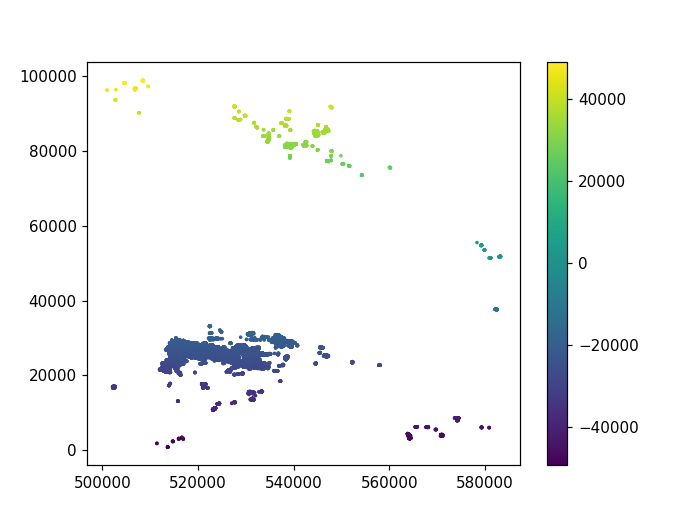

In [12]:
%matplotlib notebook
plt.scatter(x=df.x, y=df.y, c=df.offsetY, marker='.', s=8)
plt.colorbar()
plt.show()

In [13]:
df.shape

(84381, 34)

<IPython.core.display.Javascript object>


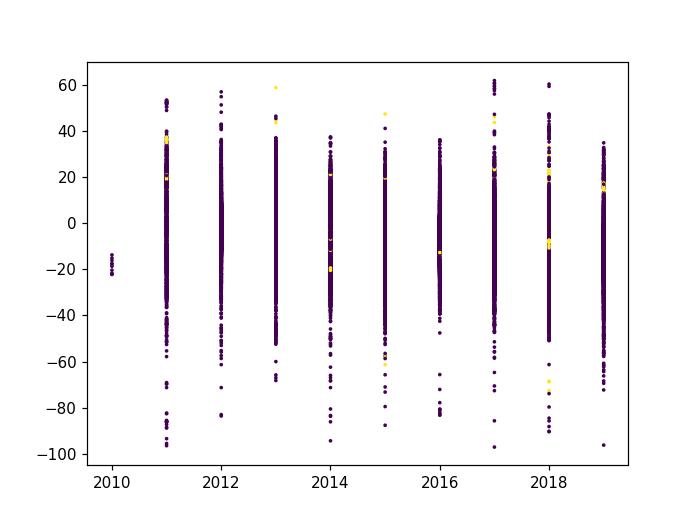

In [14]:
%matplotlib notebook
plt.scatter(x=df.gla_year, y=df.refDifference, c=df.within_Debris, marker='.', s=8, label=['debris', 'no-debris'])
#plt.legend()
plt.show()

<IPython.core.display.Javascript object>


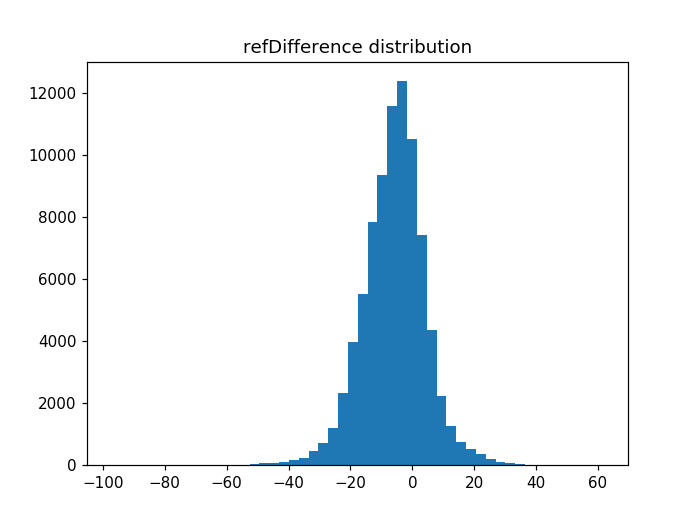

In [15]:
%matplotlib notebook
plt.hist(df.refDifference, bins=50)
plt.title('refDifference distribution')
plt.show()

<IPython.core.display.Javascript object>


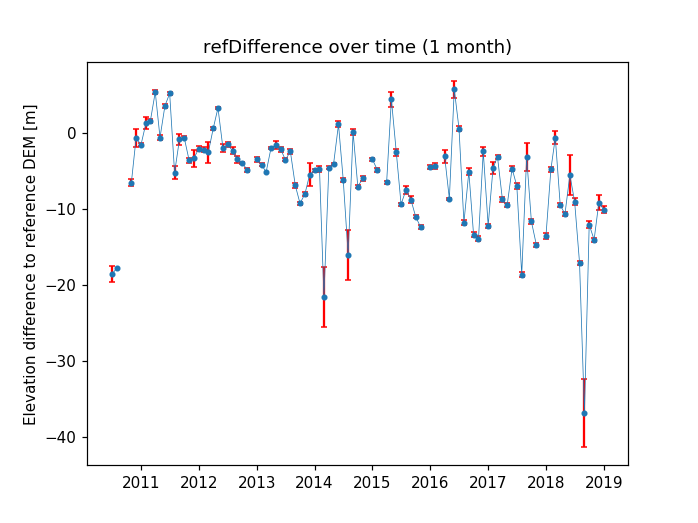

In [17]:
%matplotlib notebook
from dateutil.relativedelta import *
#averages = df.groupby(['year','month']).refDifference.mean()
averages = []
dates = []
errors = []

use_date = datetime.datetime(2010,1,1,0,0)
while use_date <= datetime.datetime(2019,1,1,0,0):
    df_filt = df[(df.month == use_date.month) & (df.year == use_date.year)]
    averages.append(df_filt.refDifference.mean())
    dates.append(use_date)
    errors.append(df_filt.refDifference.sem())
    #df_filt = df.query('month=%s && year=%s'  % (use_date.month, use_date.year))
    use_date = use_date+relativedelta(months=+1)

plt.errorbar(x=dates, y=averages, yerr=errors, marker='.', ecolor='red', elinewidth=1.5, capsize=2, linewidth=0.5)
plt.title('refDifference over time (1 month)')
plt.ylabel('Elevation difference to reference DEM [m]')
plt.show()

In [18]:
# do it for 90 days
from dateutil.relativedelta import *
#averages = df.groupby(['year','month']).refDifference.mean()
averages = []
dates = []
errors = []
changes = []

use_date = datetime.datetime(2010,11,1,0,0)
while use_date <= datetime.datetime(2019,1,1,0,0):
    df_filt = df[(df.dateobject >= use_date) & (df.dateobject <(use_date+relativedelta(months=+3)))]
    averages.append(df_filt.refDifference.mean())
    dates.append(use_date)
    errors.append(df_filt.refDifference.sem())
    #df_filt = df.query('month=%s && year=%s'  % (use_date.month, use_date.year))
    use_date = use_date+relativedelta(months=+3)

for i in averages:
            changes.append(i-averages[0])

<IPython.core.display.Javascript object>


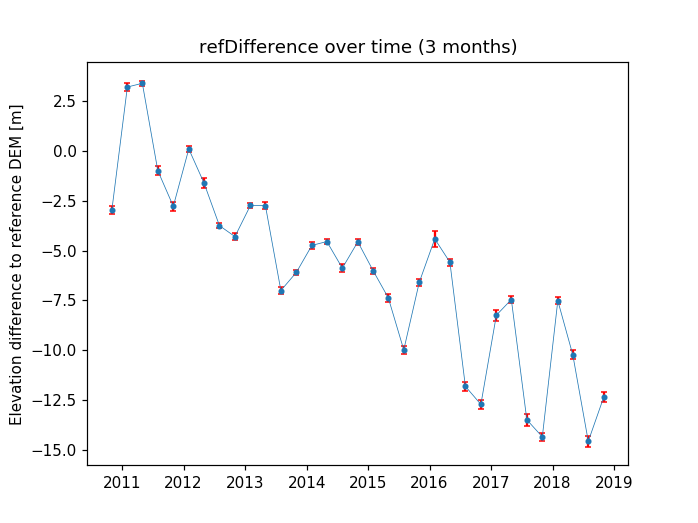

In [19]:
%matplotlib notebook
# plot dem diff over time
plt.errorbar(x=dates, y=averages, yerr=errors, marker='.', ecolor='red', elinewidth=1.5, capsize=2, linewidth=0.5)
plt.title('refDifference over time (3 months)')
plt.ylabel('Elevation difference to reference DEM [m]')
plt.show()

<IPython.core.display.Javascript object>


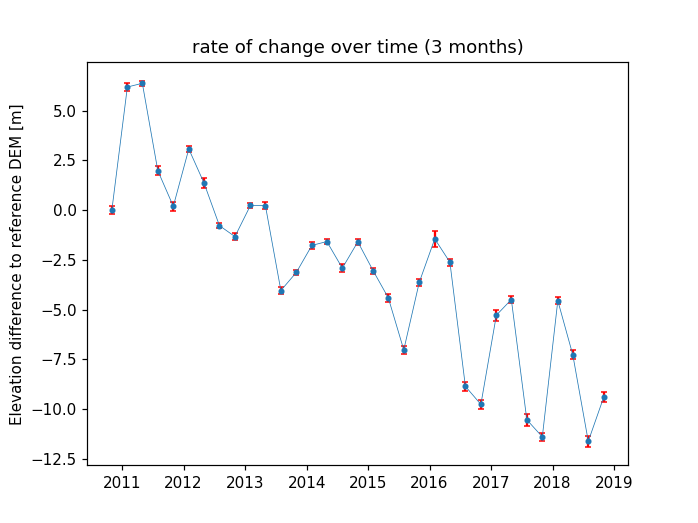

In [20]:
%matplotlib notebook
# plot dem diff over time
plt.errorbar(x=dates, y=changes, yerr=errors, marker='.', ecolor='red', elinewidth=1.5, capsize=2, linewidth=0.5)
plt.title('rate of change over time (3 months)')
plt.ylabel('Elevation difference to reference DEM [m]')
plt.show()

<IPython.core.display.Javascript object>


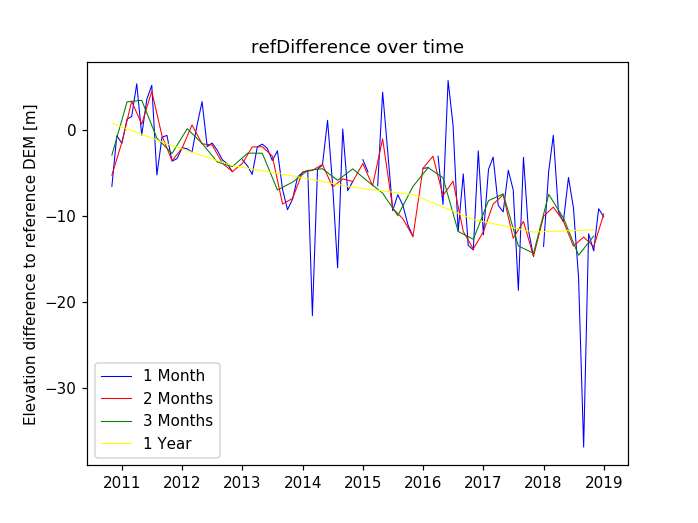

In [21]:
%matplotlib notebook
# do it for 90 days
from dateutil.relativedelta import *
#averages = df.groupby(['year','month']).refDifference.mean()

one_m_dates = []
one_m = []

two_m_dates = []
two_m = []

three_m_dates = []
three_m = []

year_dates = []
year = []

# 1 month
use_date = datetime.datetime(2010,11,1,0,0)
while use_date <= datetime.datetime(2019,1,1,0,0):
    df_filt = df[(df.dateobject >= use_date) & (df.dateobject <(use_date+relativedelta(months=+1)))]
    one_m.append(df_filt.refDifference.mean())
    one_m_dates.append(use_date)
    use_date = use_date+relativedelta(months=+1)

# 2 months
use_date = datetime.datetime(2010,11,1,0,0)
while use_date <= datetime.datetime(2019,1,1,0,0):
    df_filt = df[(df.dateobject >= use_date) & (df.dateobject <(use_date+relativedelta(months=+2)))]
    two_m.append(df_filt.refDifference.mean())
    two_m_dates.append(use_date)
    use_date = use_date+relativedelta(months=+2)
    
# 3 months
use_date = datetime.datetime(2010,11,1,0,0)
while use_date <= datetime.datetime(2019,1,1,0,0):
    df_filt = df[(df.dateobject >= use_date) & (df.dateobject <(use_date+relativedelta(months=+3)))]
    three_m.append(df_filt.refDifference.mean())
    three_m_dates.append(use_date)
    use_date = use_date+relativedelta(months=+3)
    
# 1 year
use_date = datetime.datetime(2010,11,1,0,0)
while use_date <= datetime.datetime(2019,1,1,0,0):
    df_filt = df[(df.dateobject >= use_date) & (df.dateobject <(use_date+relativedelta(months=+12)))]
    year.append(df_filt.refDifference.mean())
    year_dates.append(use_date)
    use_date = use_date+relativedelta(months=+12)

plt.plot(one_m_dates, one_m, linewidth=0.7, color='blue', label='1 Month')
plt.plot(two_m_dates, two_m, linewidth=0.7, color='red', label='2 Months')
plt.plot(three_m_dates, three_m, linewidth=0.7, color='green', label='3 Months')
plt.plot(year_dates, year, linewidth=0.7, color='yellow', label='1 Year')
plt.legend(loc='lower left')
plt.title('refDifference over time')
plt.ylabel('Elevation difference to reference DEM [m]')
plt.show()